In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
%matplotlib inline

def print_score(y_pred, y_real, y_score, label_encoder, model_name):
    data = []

    data.append(["Accuracy", accuracy_score(y_real, y_pred)])
    data.append(["Precision (macro)", precision_score(y_real, y_pred, average='macro', zero_division=1)])
    data.append(["Recall (macro)", recall_score(y_real, y_pred, average='macro', zero_division=0)])
    data.append(["F1-score (macro)", f1_score(y_real, y_pred, average='macro', zero_division=0)])
    data.append(["AUC-ROC (macro)", roc_auc_score(y_real, y_score, multi_class='ovr', average='macro')])

    for i in range(len(label_encoder.classes_)):
        class_name = label_encoder.inverse_transform([i])[0]
        data.append([f"Precision ({class_name})", precision_score(y_real, y_pred, labels=[i], average='weighted', zero_division=1)])
        data.append([f"Recall ({class_name})", recall_score(y_real, y_pred, labels=[i], average='weighted', zero_division=0)])
        data.append([f"F1-score ({class_name})", f1_score(y_real, y_pred, labels=[i], average='weighted', zero_division=0)])

    score_df = pd.DataFrame(data, columns=["Metric", "Value"])
    display(score_df)

    # Save the score DataFrame to a CSV file
    score_df.to_csv(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_metrics.csv", index=False)


def plot_roc_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)

    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 6))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_roc_curve.png", bbox_inches='tight')  # Move this line before plt.show()
        plt.show()
    else:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:, i], pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 6))
        for i in range(n_classes):
            class_name = label_encoder.inverse_transform([i])[0]
            plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_name, roc_auc[i]))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_roc_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()


from sklearn.metrics import PrecisionRecallDisplay

def plot_precision_recall_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)

    if n_classes == 2:
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        average_precision = average_precision_score(y_true, y_score)

        plt.figure(figsize=(10, 6))  # Change the figure size here
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_precision_recall_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()
    else:
        y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))
        precision = dict()
        recall = dict()
        average_precision = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_true_binarized[:, i], y_score[:, i], average=None)

        # Plot Precision-Recall curve for each class
        plt.figure(figsize=(10, 6))  # Change the figure size here
        for i in range(n_classes):
            disp = PrecisionRecallDisplay(precision=precision[i], recall=recall[i])
            class_name = label_encoder.inverse_transform([i])[0]
            disp.plot(ax=plt.gca(), label='Precision-recall curve of class {0} (AP = {1:0.2f})'.format(class_name, average_precision[i]))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_precision_recall_curve.png", bbox_inches='tight')  # Move this line before plt.show() and correct the filename
        plt.show()

def plot_class_accuracy(y_true, y_pred, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    class_counts = np.zeros(n_classes)
    class_corrects = np.zeros(n_classes)

    for t, p in zip(y_true, y_pred):
        class_counts[t] += 1
        if t == p:
            class_corrects[t] += 1

    class_accuracies = class_corrects / class_counts
    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_accuracies)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    plt.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_class_accuracy.png", bbox_inches='tight')  # Move this line before plt.show()
    plt.show()

def plot_class_f1_score(y_true, y_pred, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)
    f1_scores = []

    for i in range(n_classes):
        class_f1_score = f1_score(y_true, y_pred, labels=[i], average='weighted')
        f1_scores.append(class_f1_score)

    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, f1_scores)
    plt.xlabel('Class')
    plt.ylabel('F1-score')
    plt.title('F1-score per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    fig = plt.gcf()  # Get the current figure
    plt.show()

    # Save the figure to an image file
    fig.savefig(f"/content/drive/MyDrive/Results/{model_name}_UNSW_NB15_class_f1_score.png", bbox_inches='tight')

# # Load the dataset
file_path = '/content/drive/MyDrive/UNSW_NB15_training-set.csv'
df = pd.read_csv(file_path)


In [7]:
import tensorflow as tf

embedding_size = 128  # Choose the desired embedding size
X = df.iloc[:, :-1]  # Get all columns except the last one as input features
num_features = X.shape[1]
num_samples = X.shape[0]  # Get the number of samples

# Define the input and embedding layer
input_features = tf.keras.layers.Input(shape=(num_features,))
embedding_layer = tf.keras.layers.Dense(embedding_size, activation='relu')
embeddings = embedding_layer(input_features)

# Positional encoding functions
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    pos_encoding = np.zeros((position, d_model), dtype=np.float32)
    pos_encoding[0::2, :] = np.sin(angle_rads[0::2, :])
    pos_encoding[1::2, :] = np.cos(angle_rads[1::2, :])
    return tf.cast(pos_encoding, dtype=tf.float32)

# Add positional encoding to the embeddings
position = num_features  # Number of positions equal to the number of samples
embeddings_with_pos_enc = positional_encoding(position, embedding_size) + embeddings

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE


def position_wise_feed_forward(inputs, d_ff):
    x = Dense(units=d_ff, activation='relu')(inputs)
    x = Dense(units=d_model)(x)
    return x

def multi_head_self_attention(inputs, d_model, num_heads, dropout_rate):
    depth = d_model // num_heads
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=depth, dropout=0.1)
    x = attention(inputs, inputs)
    return x

def encoder_layer(inputs, d_model, num_heads, d_ff, dropout_rate=0.1):
    x = multi_head_self_attention(inputs, d_model, num_heads, dropout_rate)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization(epsilon=1e-6)(inputs + x)

    ff = position_wise_feed_forward(x, d_ff)
    x = Dropout(dropout_rate)(ff)
    x = LayerNormalization(epsilon=1e-6)(x + ff)

    return x

class BroadcastPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(BroadcastPositionalEncoding, self).__init__()
        self.pos_encoding = positional_encoding(position, d_model)

    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.pos_encoding[:shape[0], :shape[1]]

def create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes, dropout_rate=0.1):
    inputs = Input(shape=input_shape)

    # Embedding layer
    embedding_layer = Dense(d_model, activation='relu')
    embeddings = embedding_layer(inputs)

    # Reshape the embeddings to be 3D tensor.
    x = tf.expand_dims(embeddings, axis=1)

    # Broadcast Positional Encoding
    x = BroadcastPositionalEncoding(input_shape[0], d_model)(x) # Apply it on 'x', not 'embeddings'


    # Encoder layers
    for _ in range(num_layers):
        x = encoder_layer(x, d_model, num_heads, d_ff, dropout_rate)

    # Apply GlobalAveragePooling1D
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)

    # Final softmax layer to predict num_classes
    outputs = Dense(units=num_classes)(x)
    print("Shape of model output before softmax: ", outputs.shape)
    outputs = tf.keras.layers.Softmax(axis=-1)(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Preprocess the dataset
# Convert categorical variables to dummy variables
cat_columns = ['proto', 'service', 'state']
df = pd.get_dummies(df, columns=cat_columns)

# The column to predict is now 'attack_cat'
le = LabelEncoder()
df['attack_cat'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Anomaly')
df['attack_cat'] = le.fit_transform(df['attack_cat'])

# Everything else is a feature
X = df.drop(['attack_cat', 'label'], axis=1).values
y = df['attack_cat'].values

print("Shape of Input Data (Features): ", X.shape)
print("Shape of Output Data (Labels): ", y.shape)

# Apply feature selection, normalization, etc.
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# # Apply feature scaling again
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


assert not np.isnan(X_train).any(), "X_train contains NaN values"
assert not np.isnan(X_test).any(), "X_test contains NaN values"



# Set parameters for the model
input_shape = X_train.shape[1:]
d_model = 128  # Select an embedding size for the model
d_ff = 256
num_heads = 4
num_layers = 4
num_classes = len(np.unique(y_train))

# Create and compile the model
model = create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the Transformer-based IDS model
batch_size = 64
epochs = 20

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Learning rate scheduler
def learning_rate_scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Keep the initial learning rate for the first 10 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Exponential decay for learning rate after 10 epochs

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Learning rate warmup
def learning_rate_warmup_scheduler(epoch, lr):
    if epoch < 5:
        return lr * (epoch + 1) / 5
    else:
        return lr

# Create and compile the model
model = create_transformer_ids_model(input_shape, d_model, d_ff, num_heads, num_layers, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with the callbacks
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler),
        early_stopping,
        tf.keras.callbacks.LearningRateScheduler(learning_rate_warmup_scheduler),
        checkpoint
    ]
)

# Load the saved weights into a new model
model.load_weights('best_model.h5')

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate prediction probabilities
y_score = model.predict(X_test)

Shape of Input Data (Features):  (82332, 191)
Shape of Output Data (Labels):  (82332,)
Shape of model output before softmax:  (None, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 191)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 128)          24576       ['input_2[0][0]']                
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 1, 128)       0           ['dense_1[0][0]']                
                                                                                                  
 broadcast_positional_encoding   (None, None, 128)   0   

SVM 


,Metric,Value
0,Accuracy,0.965466
1,Precision (macro),0.966173
2,Recall (macro),0.964151
3,F1-score (macro),0.965063
4,AUC-ROC (macro),0.991008
5,Precision (Anomaly),0.960145
6,Recall (Anomaly),0.977643
7,F1-score (Anomaly),0.968815
8,Precision (Normal),0.972202
9,Recall (Normal),0.950659


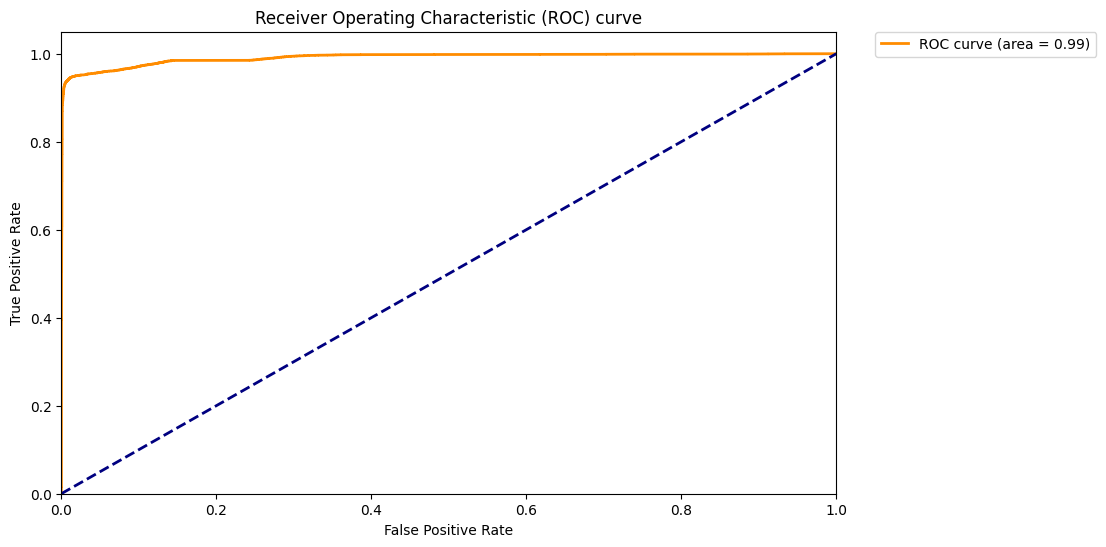

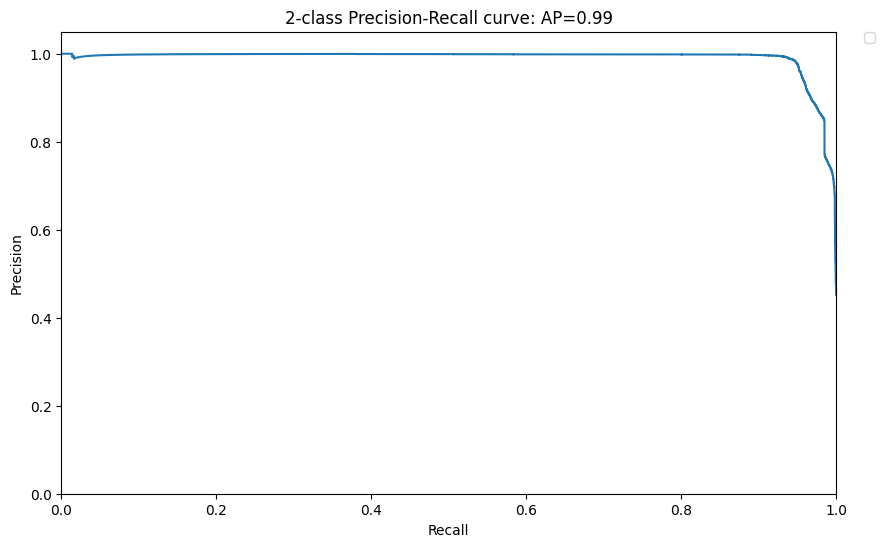

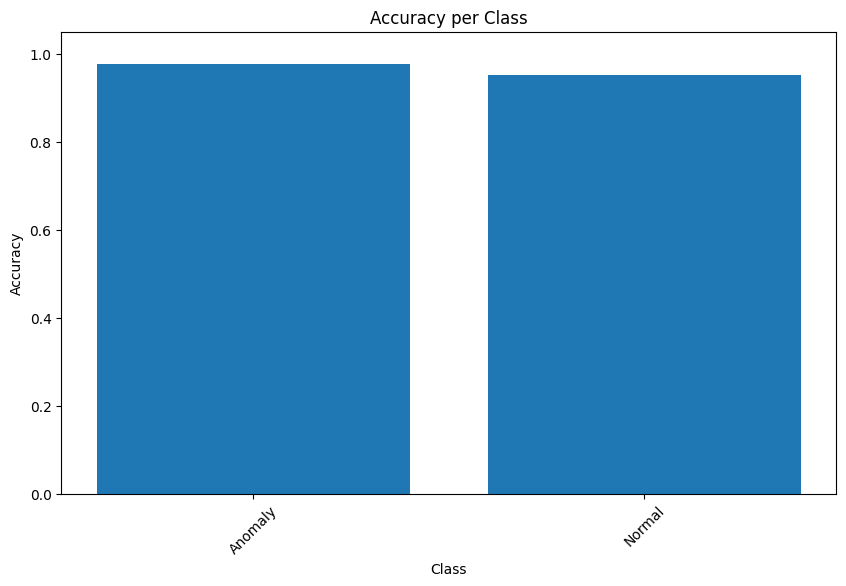

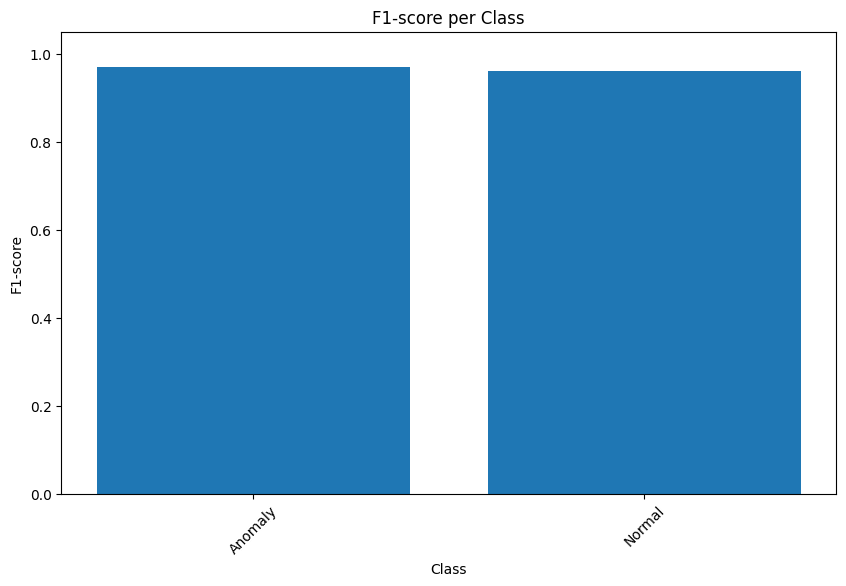

In [3]:
# from sklearn.svm import SVC

# model_name = 'SVM'

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# df['attack_cat'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Anomaly')
# y = df['attack_cat']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Train the SVM Classifier
# svm_classifier = SVC(probability=True, random_state=42)
# svm_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = svm_classifier.predict(X_test_scaled)

# # Calculate prediction probabilities for the positive class
# y_score = svm_classifier.predict_proba(X_test_scaled)[:, 1]

# # Print scores
# print("SVM ")
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_roc_curve(y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)


KNN 


,Metric,Value
0,Accuracy,0.975668
1,Precision (macro),0.975014
2,Recall (macro),0.975964
3,F1-score (macro),0.975460
4,AUC-ROC (macro),0.994738
5,Precision (Anomaly),0.982563
6,Recall (Anomaly),0.972921
7,F1-score (Anomaly),0.977718
8,Precision (Normal),0.967465
9,Recall (Normal),0.979008


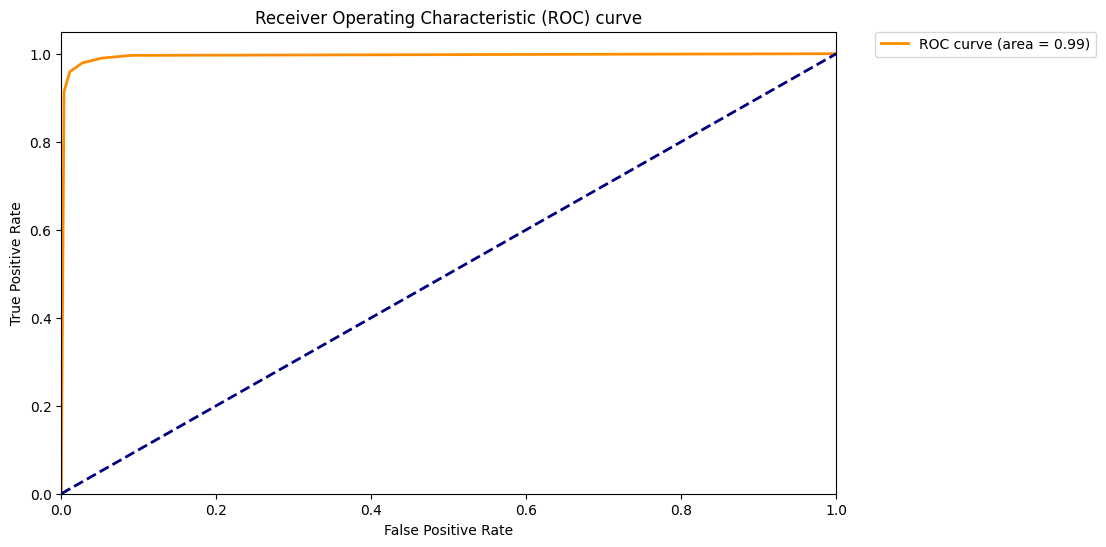

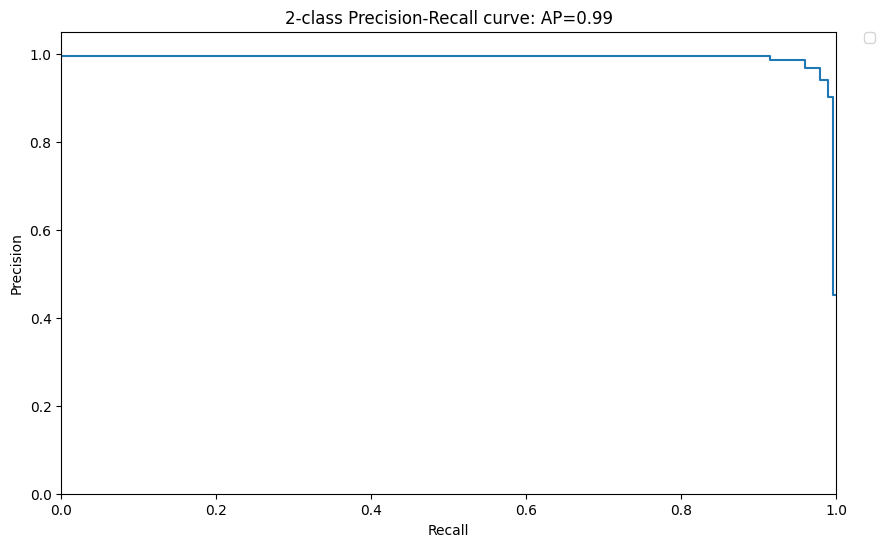

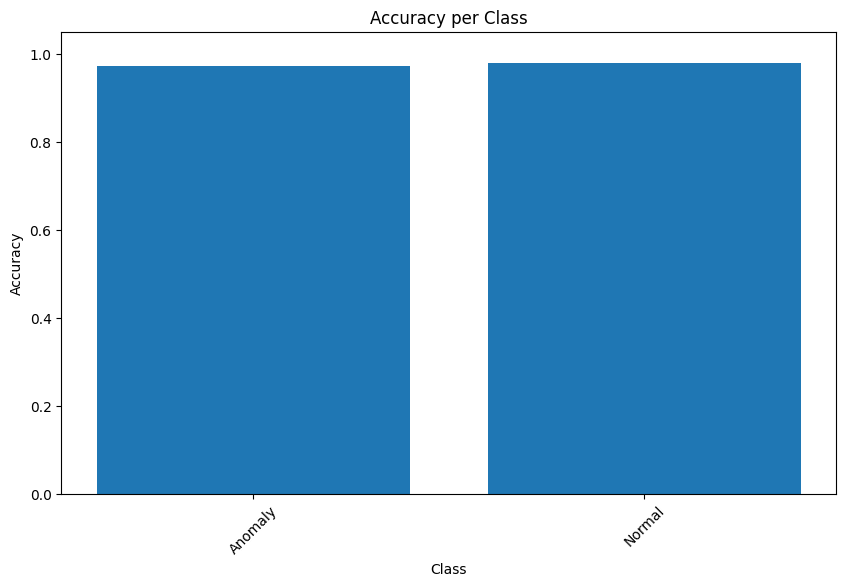

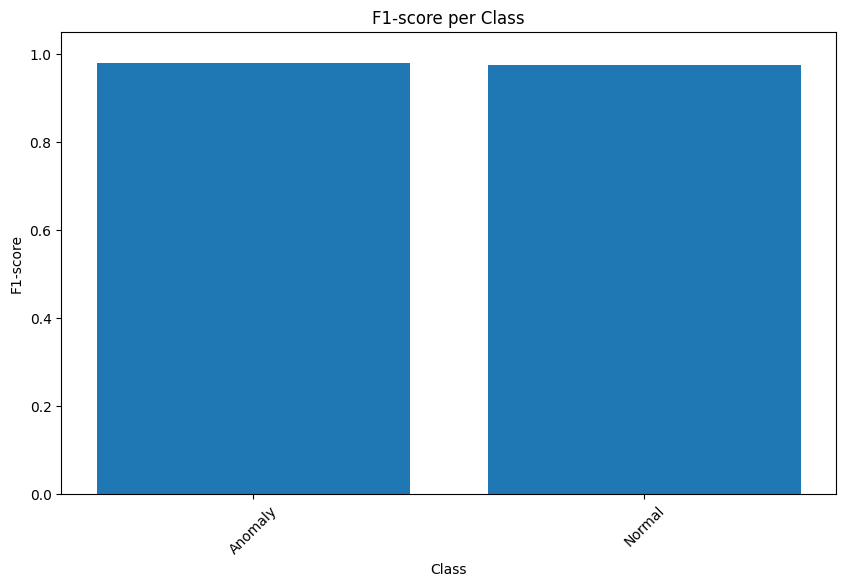

In [5]:
from sklearn.neighbors import KNeighborsClassifier

model_name = 'KNN'

# Convert categorical variables to dummy variables
cat_columns = ['proto', 'service', 'state']
df = pd.get_dummies(df, columns=cat_columns)

# Split the dataset into features and target
X = df.drop(['attack_cat', 'label'], axis=1)
df['attack_cat'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Anomaly')
y = df['attack_cat']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the K-Nearest Neighbors Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = knn_classifier.predict(X_test_scaled)

# Calculate prediction probabilities for the positive class
y_score = knn_classifier.predict_proba(X_test_scaled)[:, 1]

# Print scores
print("KNN ")
print_score(y_pred, y_test, y_score, label_encoder, model_name)
plot_roc_curve(y_test, y_score, label_encoder, model_name)
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
plot_class_f1_score(y_test, y_pred, label_encoder, model_name)


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# model_name = 'CNN'

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# df['attack_cat'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Anomaly')
# y = df['attack_cat']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Reshape the input data into 3D format for use with Conv1D (samples, timesteps, features)
# X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
# X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# # Define the CNN architecture
# model = Sequential()
# model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Conv1D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# # Train the model
# model.fit(X_train_scaled, y_train, batch_size=64, epochs=50, validation_split=0.2,  callbacks=[early_stopping])

# # Evaluate the model
# score = model.evaluate(X_test_scaled, y_test)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

# # Make predictions
# y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# # Calculate prediction probabilities
# y_score = model.predict(X_test_scaled)

# # Print scores
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_roc_curve(y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)


Epoch 1/50
721/721 [==============================] - 7s 7ms/step - loss: 0.1444 - accuracy: 0.9397 - val_loss: 0.0612 - val_accuracy: 0.9844
Epoch 2/50
721/721 [==============================] - 4s 6ms/step - loss: 0.0593 - accuracy: 0.9812 - val_loss: 0.0398 - val_accuracy: 0.9878
Epoch 3/50
721/721 [==============================] - 5s 7ms/step - loss: 0.0437 - accuracy: 0.9861 - val_loss: 0.0335 - val_accuracy: 0.9889
Epoch 4/50
721/721 [==============================] - 4s 6ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.0224 - val_accuracy: 0.9934
Epoch 5/50
721/721 [==============================] - 4s 5ms/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.0204 - val_accuracy: 0.9933
Epoch 6/50
721/721 [==============================] - 4s 6ms/step - loss: 0.0259 - accuracy: 0.9921 - val_loss: 0.0238 - val_accuracy: 0.9919
Epoch 7/50
721/721 [==============================] - 5s 7ms/step - loss: 0.0219 - accuracy: 0.9930 - val_loss: 0.0197 - val_accuracy: 0.9944
Epoch 

Epoch 1/100
721/721 [==============================] - 10s 10ms/step - loss: 0.2739 - accuracy: 0.8761 - val_loss: 0.1184 - val_accuracy: 0.9559
Epoch 2/100
721/721 [==============================] - 6s 9ms/step - loss: 0.1342 - accuracy: 0.9465 - val_loss: 0.0845 - val_accuracy: 0.9699
Epoch 3/100
721/721 [==============================] - 6s 9ms/step - loss: 0.1046 - accuracy: 0.9573 - val_loss: 0.0723 - val_accuracy: 0.9692
Epoch 4/100
721/721 [==============================] - 7s 10ms/step - loss: 0.0926 - accuracy: 0.9613 - val_loss: 0.0605 - val_accuracy: 0.9748
Epoch 5/100
721/721 [==============================] - 6s 8ms/step - loss: 0.0842 - accuracy: 0.9670 - val_loss: 0.0586 - val_accuracy: 0.9775
Epoch 6/100
721/721 [==============================] - 7s 10ms/step - loss: 0.0773 - accuracy: 0.9695 - val_loss: 0.0480 - val_accuracy: 0.9833
Epoch 7/100
721/721 [==============================] - 6s 8ms/step - loss: 0.0707 - accuracy: 0.9727 - val_loss: 0.0472 - val_accuracy: 0.

,Metric,Value
0,Accuracy,0.990688
1,Precision (macro),0.990944
2,Recall (macro),0.990265
3,F1-score (macro),0.990593
4,AUC-ROC (macro),0.999403
5,Precision (Anomaly),0.988487
6,Recall (Anomaly),0.994614
7,F1-score (Anomaly),0.991541
8,Precision (Normal),0.993401
9,Recall (Normal),0.985915


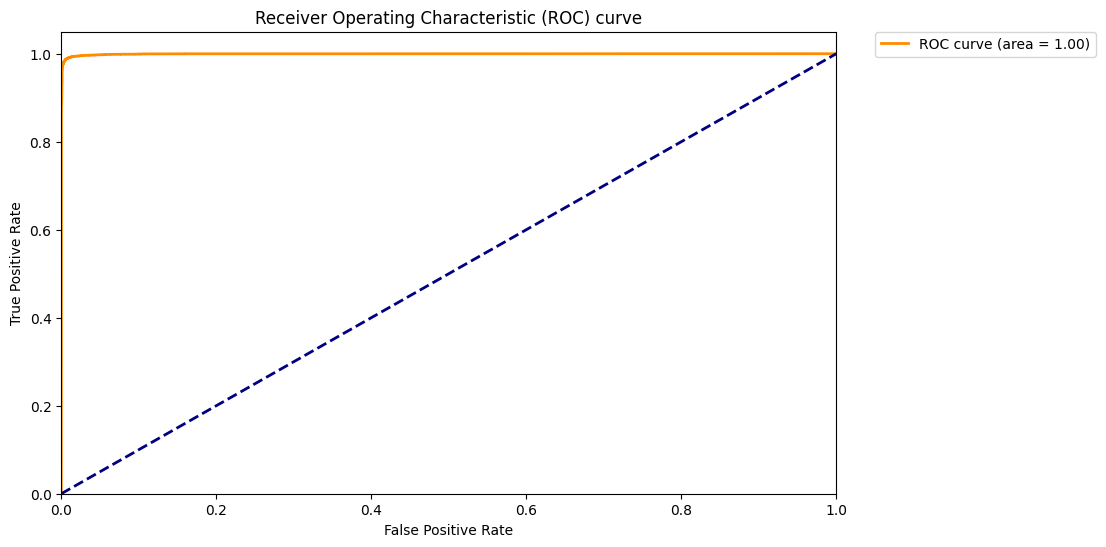

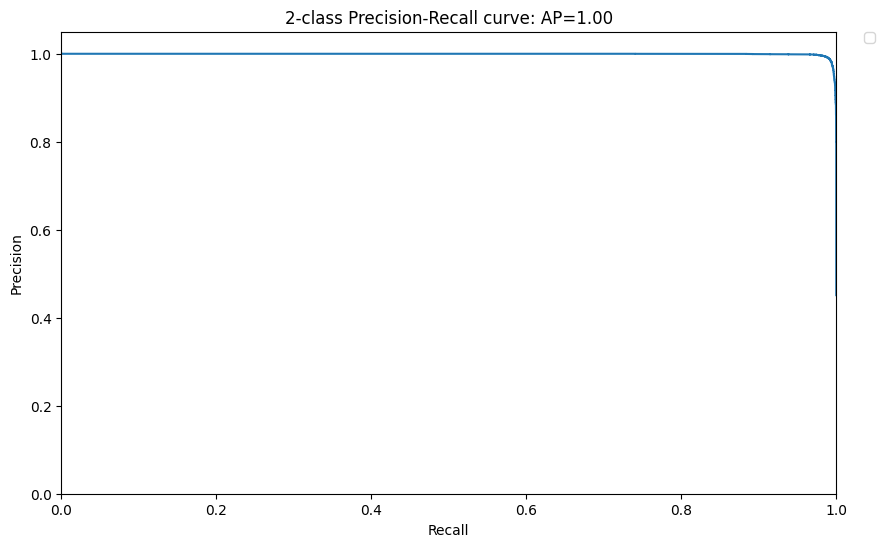

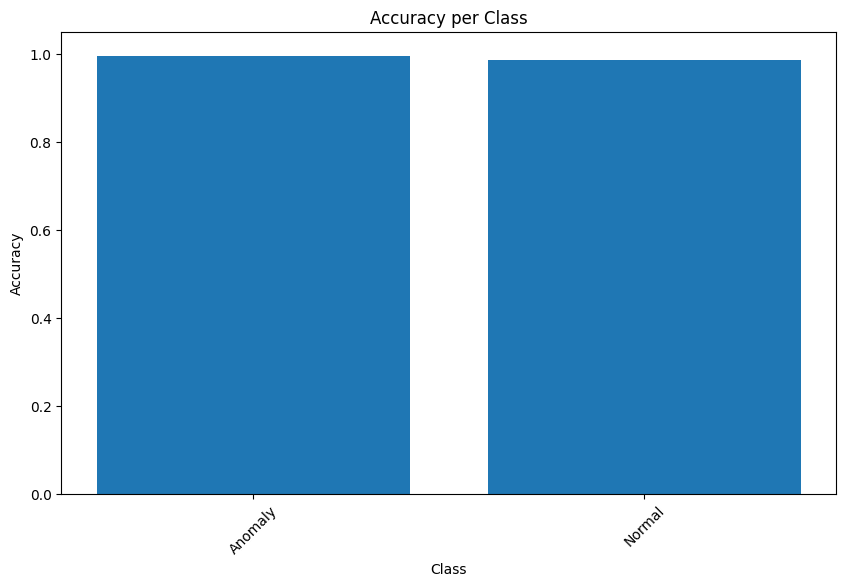

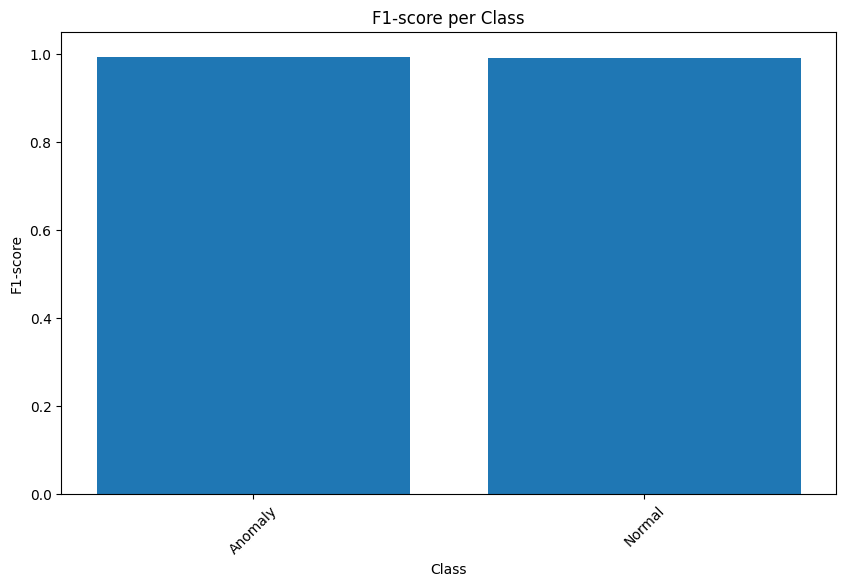

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# model_name = 'LSTM'

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# df['attack_cat'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Anomaly')
# y = df['attack_cat']

# # Encode the target variable
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Reshape the input data into 3D format for use with LSTM (samples, timesteps, features)
# timesteps = 1  # Modify this value based on the dataset's structure
# X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1])
# X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1])

# # Define the LSTM architecture
# model = Sequential()
# model.add(LSTM(32, activation='relu', input_shape=(timesteps, X_train_scaled.shape[2])))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# # Train the model
# model.fit(X_train_scaled, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# # Make predictions
# y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# # Calculate prediction probabilities
# y_score = model.predict(X_test_scaled)

# # Print scores
# print_score(y_pred, y_test, y_score, label_encoder, model_name)
# plot_roc_curve(y_test, y_score, label_encoder, model_name)
# plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)
# plot_class_accuracy(y_test, y_pred, label_encoder, model_name)
# plot_class_f1_score(y_test, y_pred, label_encoder, model_name)


,Metric,Value
0,Accuracy,0.999150
1,Precision (macro),0.999138
2,Recall (macro),0.999146
3,F1-score (macro),0.999142
4,AUC-ROC (macro),0.999146
5,Precision (Anomaly),0.999262
6,Recall (Anomaly),0.999188
7,F1-score (Anomaly),0.999225
8,Precision (Normal),0.999013
9,Recall (Normal),0.999103


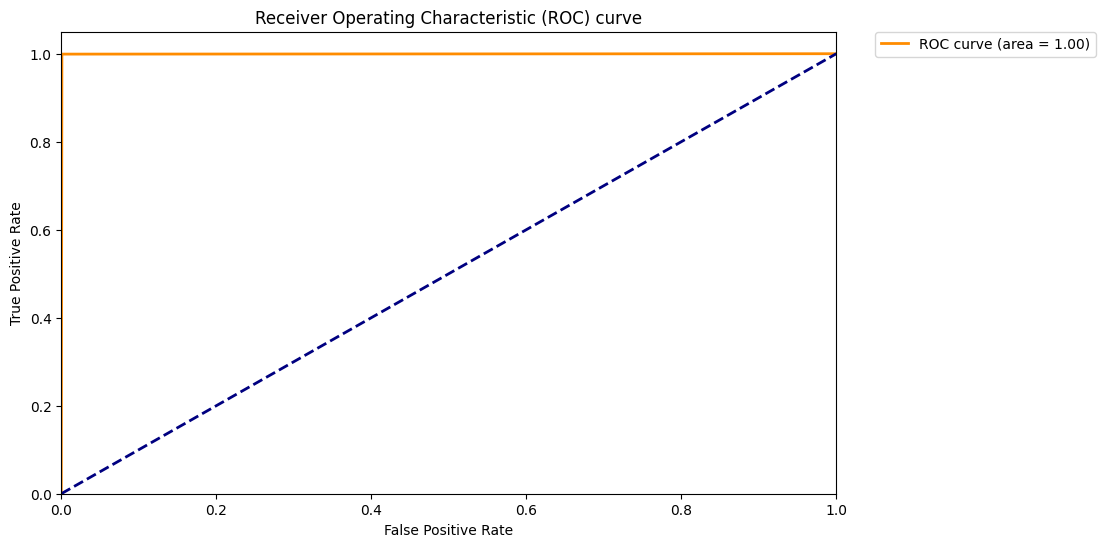

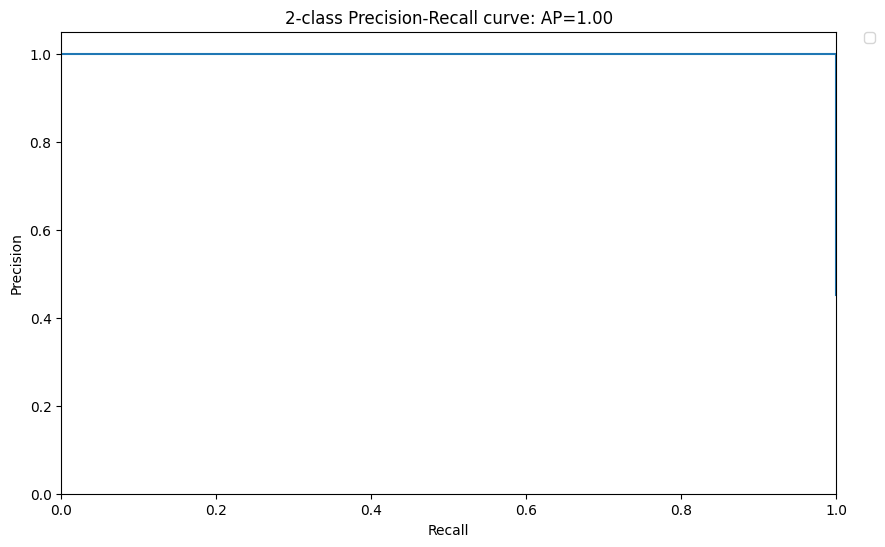

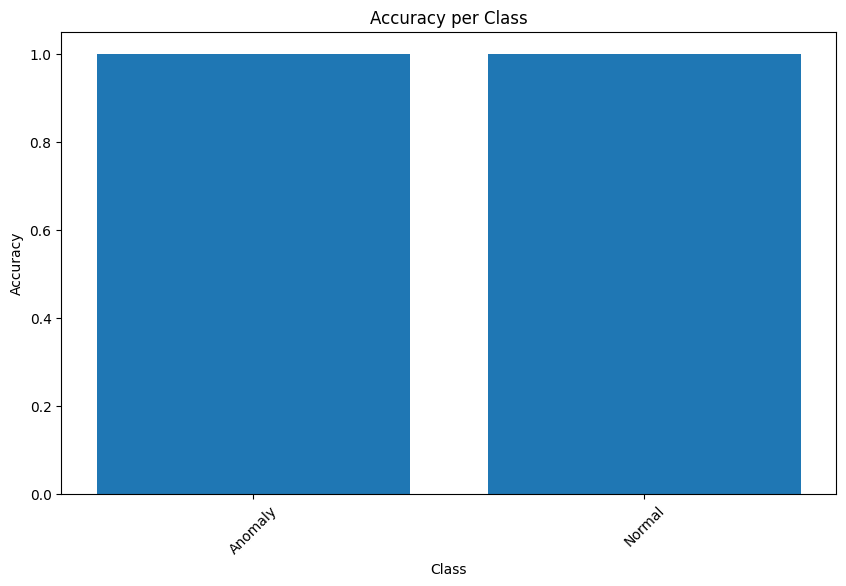

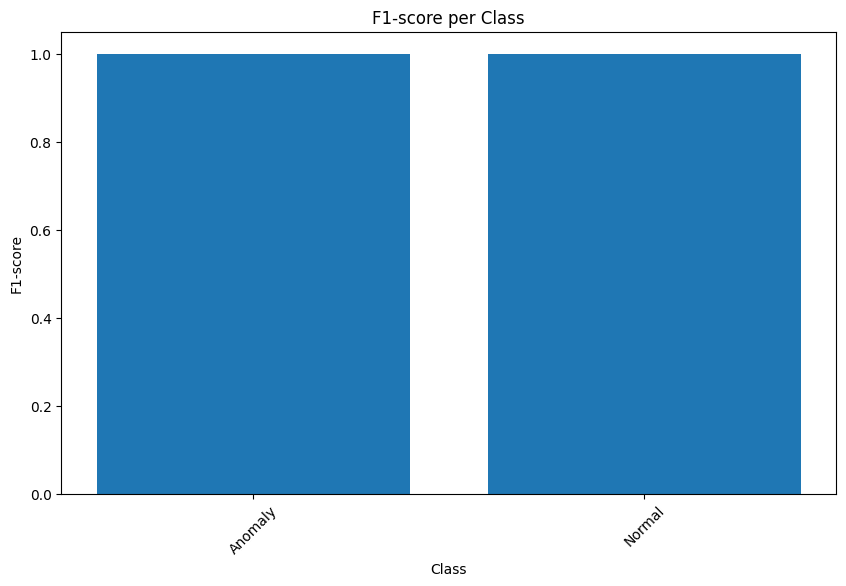

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# # Train the Decision Tree Classifier
# model_name = 'DecisionTree'

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# df['attack_cat'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Anomaly')
# y = df['attack_cat']

# # Encode the target variable
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# dt_classifier = DecisionTreeClassifier(random_state=42)
# dt_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = dt_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = dt_classifier.predict_proba(X_test_scaled)

# model_name = 'DecisionTree'
# y_score_pos = y_score[:, 1]

# # Print scores and plot metrics
# print_score(y_pred, y_test, y_score_pos, le, model_name)
# plot_roc_curve(y_test, y_score_pos, le, model_name)
# plot_precision_recall_curve(y_test, y_score_pos, le, model_name)
# plot_class_accuracy(y_test, y_pred, le, model_name)
# plot_class_f1_score(y_test, y_pred, le, model_name)

,Metric,Value
0,Accuracy,0.997045
1,Precision (macro),0.997192
2,Recall (macro),0.996845
3,F1-score (macro),0.997015
4,AUC-ROC (macro),0.999956
5,Precision (Anomaly),0.995734
6,Recall (Anomaly),0.998893
7,F1-score (Anomaly),0.997311
8,Precision (Normal),0.998649
9,Recall (Normal),0.994797


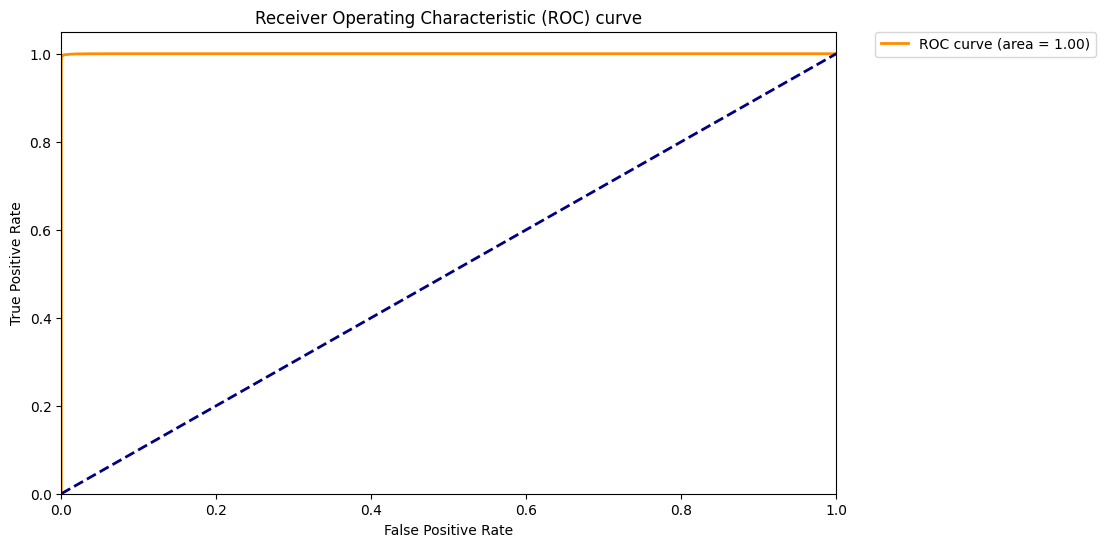

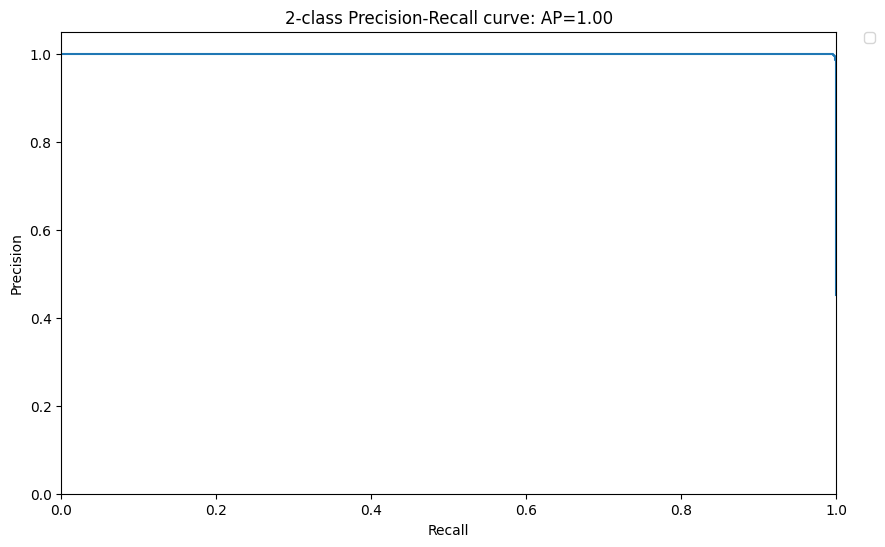

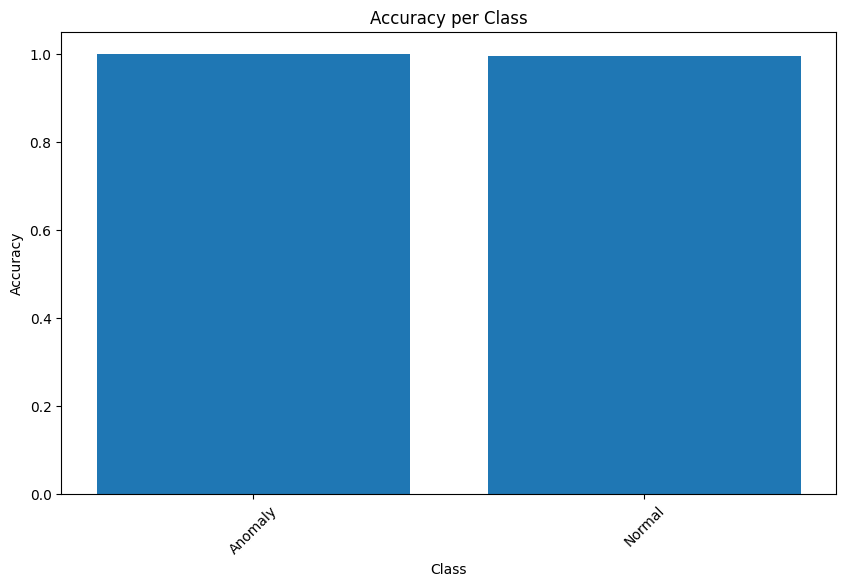

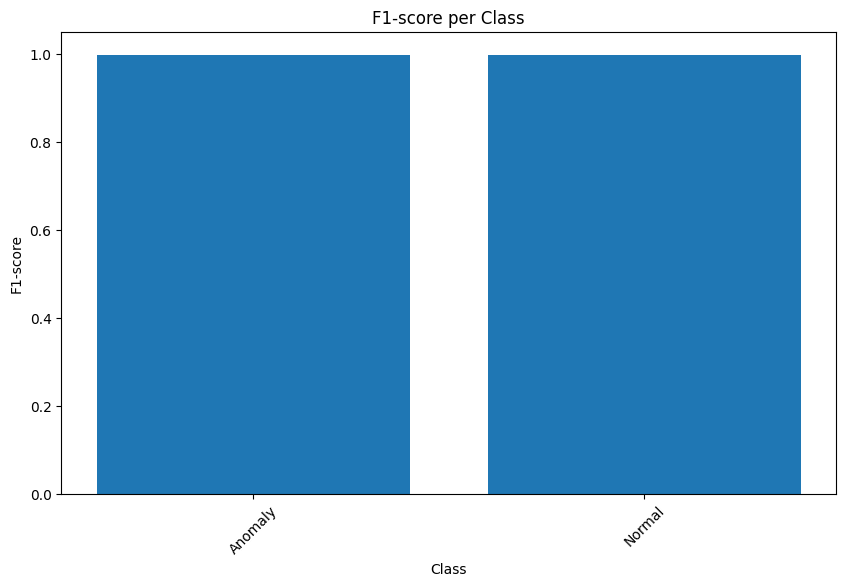

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# df['attack_cat'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Anomaly')
# y = df['attack_cat']

# # Encode the target variable
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Train the Random Forest Classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = rf_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = rf_classifier.predict_proba(X_test_scaled)

# model_name = 'RandomForest'
# y_score_pos = y_score[:, 1]

# # Print scores and plot metrics
# print_score(y_pred, y_test, y_score_pos, le, model_name)
# plot_roc_curve(y_test, y_score_pos, le, model_name)
# plot_precision_recall_curve(y_test, y_score_pos, le, model_name)
# plot_class_accuracy(y_test, y_pred, le, model_name)
# plot_class_f1_score(y_test, y_pred, le, model_name)

,Metric,Value
0,Accuracy,0.954453
1,Precision (macro),0.953982
2,Recall (macro),0.954061
3,F1-score (macro),0.954021
4,AUC-ROC (macro),0.992457
5,Precision (Anomaly),0.958869
6,Recall (Anomaly),0.958090
7,F1-score (Anomaly),0.958479
8,Precision (Normal),0.949095
9,Recall (Normal),0.950031


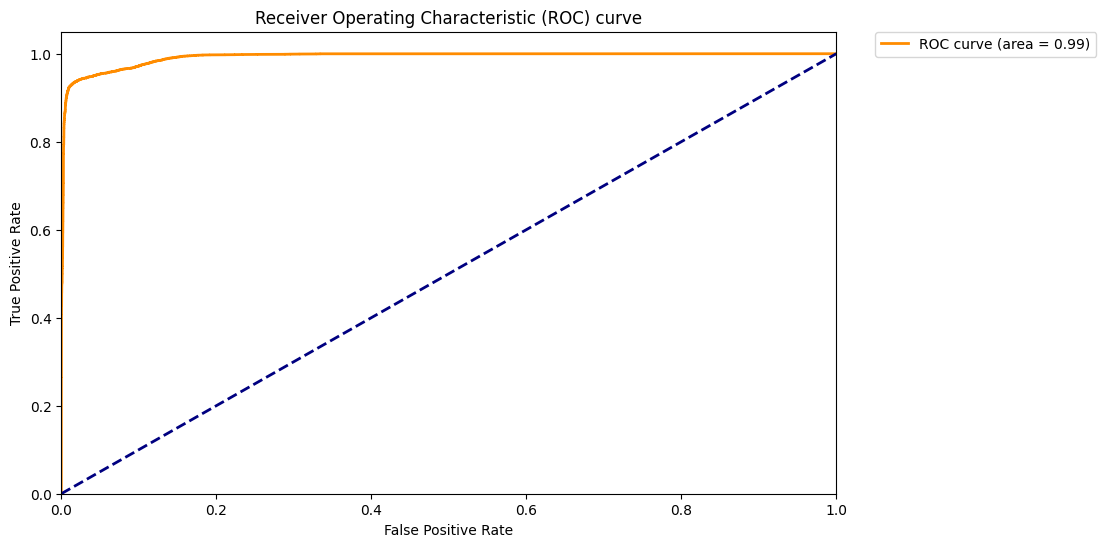

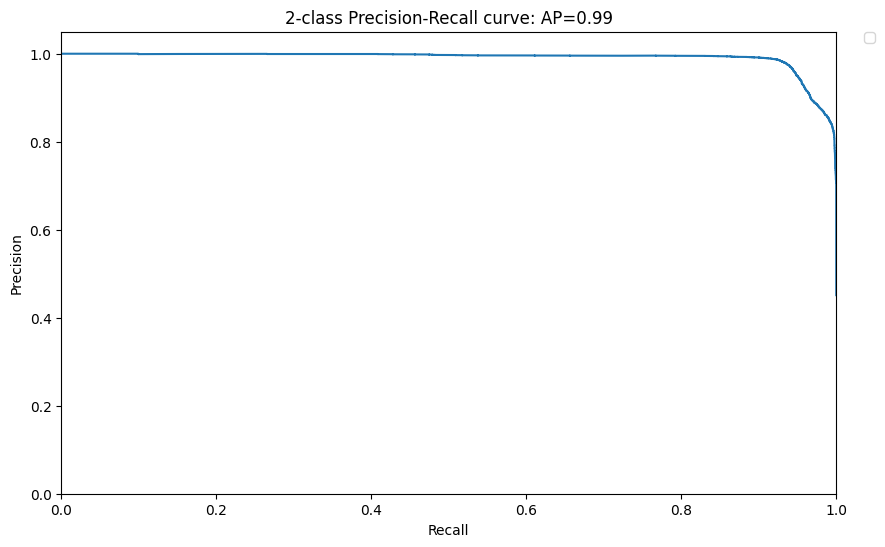

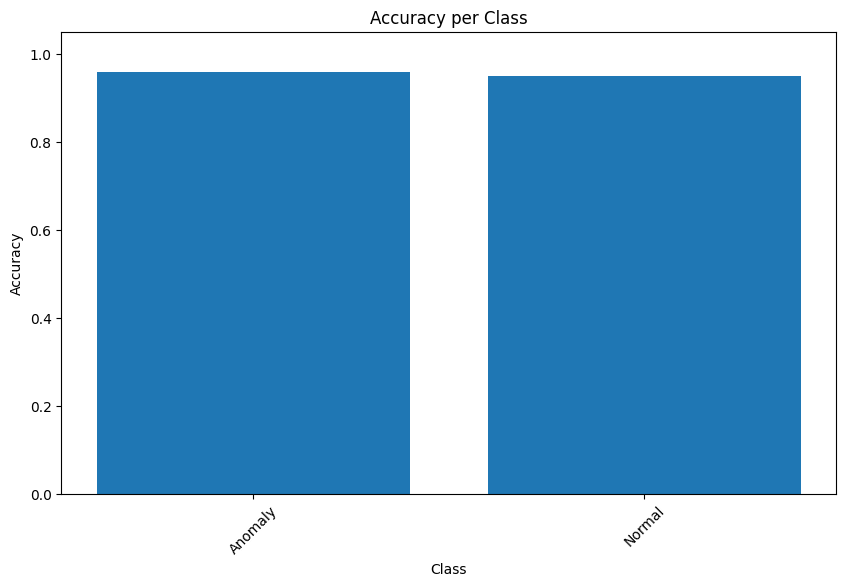

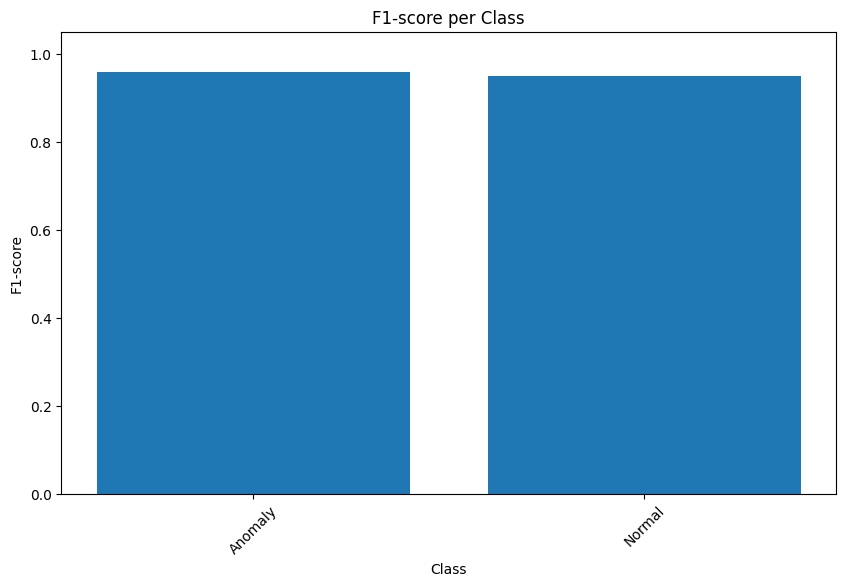

In [ ]:
# from sklearn.linear_model import LogisticRegression

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# df['attack_cat'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Anomaly')
# y = df['attack_cat']

# # Encode the target variable
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# # Train the Logistic Regression Classifier
# lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
# lr_classifier.fit(X_train_scaled, y_train)
# # Make predictions
# y_pred = lr_classifier.predict(X_test_scaled)
# # Plot ROC curve
# y_score = lr_classifier.predict_proba(X_test_scaled)

# model_name = 'LogisticRegression'
# y_score_pos = y_score[:, 1]

# # Print scores and plot metrics
# print_score(y_pred, y_test, y_score_pos, le, model_name)
# plot_roc_curve(y_test, y_score_pos, le, model_name)
# plot_precision_recall_curve(y_test, y_score_pos, le, model_name)
# plot_class_accuracy(y_test, y_pred, le, model_name)
# plot_class_f1_score(y_test, y_pred, le, model_name)

Adaboost 


,Metric,Value
0,Accuracy,1.0
1,Precision (macro),1.0
2,Recall (macro),1.0
3,F1-score (macro),1.0
4,AUC-ROC (macro),1.0
5,Precision (Anomaly),1.0
6,Recall (Anomaly),1.0
7,F1-score (Anomaly),1.0
8,Precision (Normal),1.0
9,Recall (Normal),1.0


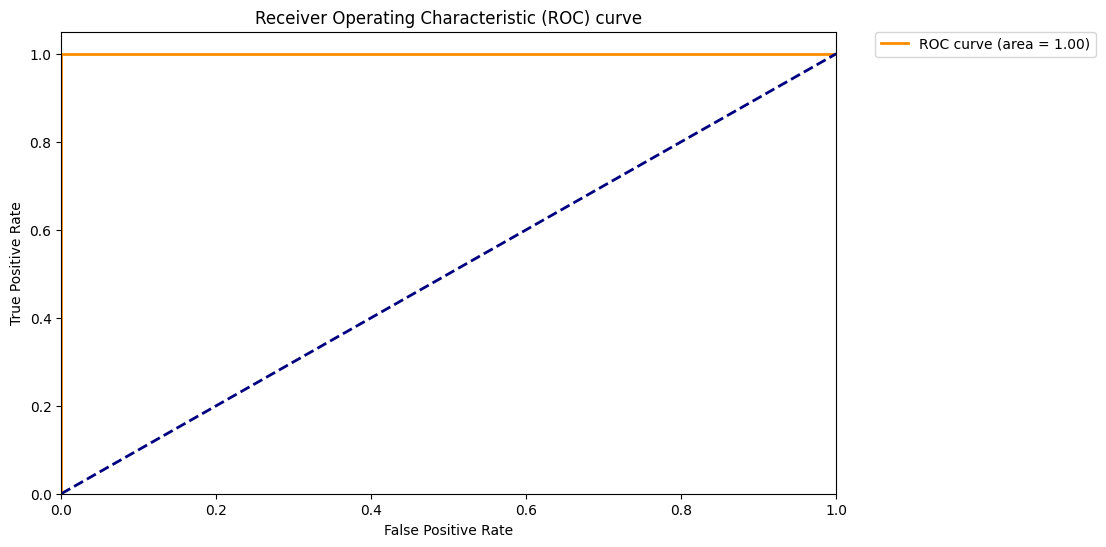

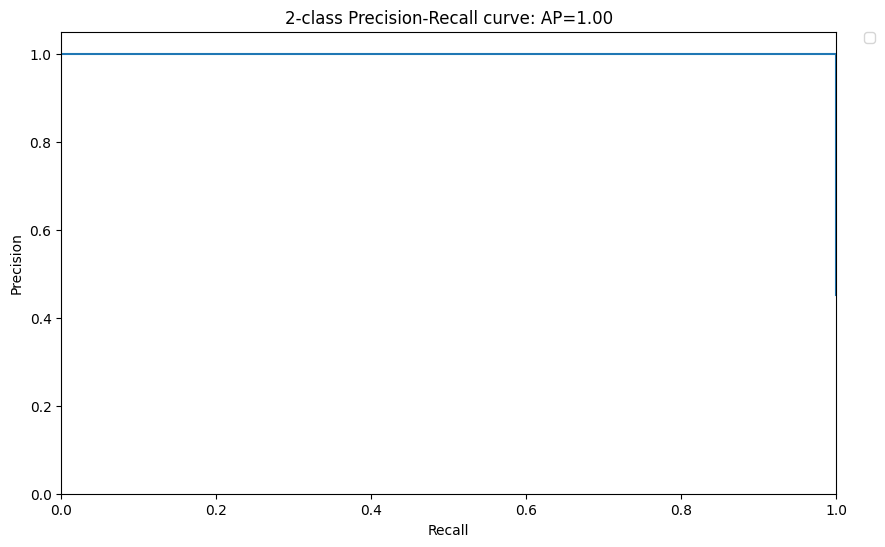

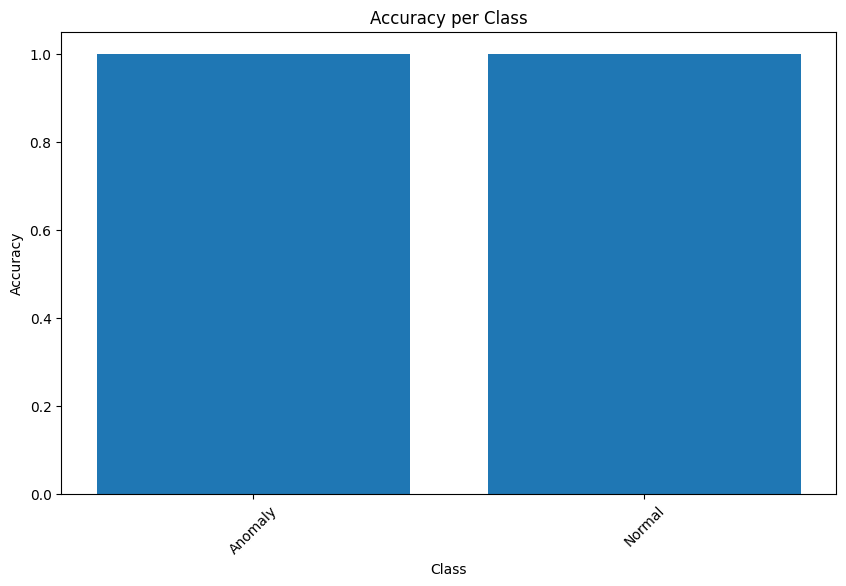

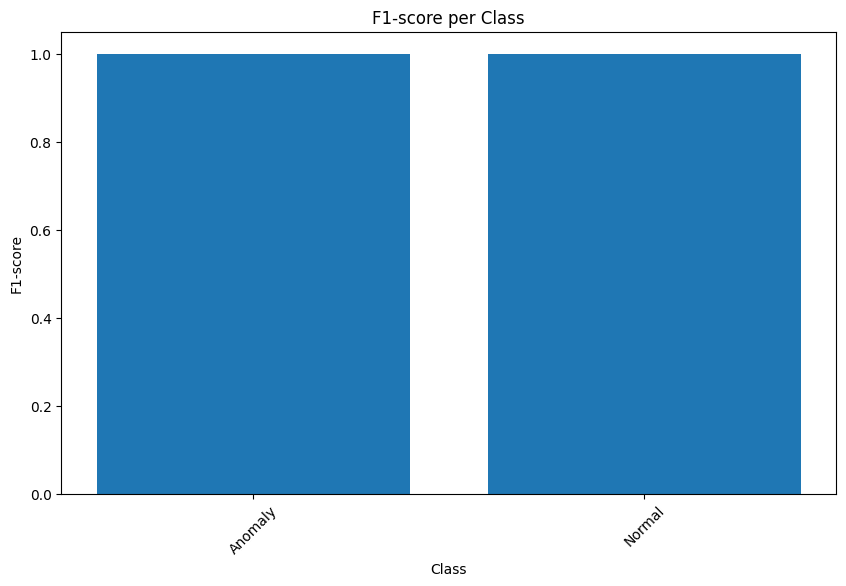

In [ ]:
# from sklearn.ensemble import AdaBoostClassifier

# # Convert categorical variables to dummy variables
# cat_columns = ['proto', 'service', 'state']
# df = pd.get_dummies(df, columns=cat_columns)

# # Split the dataset into features and target
# X = df.drop(['attack_cat', 'label'], axis=1)
# df['attack_cat'] = df['attack_cat'].apply(lambda x: 'Normal' if x == 'Normal' else 'Anomaly')
# y = df['attack_cat']

# # Encode the target variable
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# # Train the AdaBoost Classifier
# adaboost_classifier = AdaBoostClassifier(random_state=42)
# adaboost_classifier.fit(X_train_scaled, y_train)

# # Make predictions
# y_pred = adaboost_classifier.predict(X_test_scaled)

# # Plot ROC curve
# y_score = adaboost_classifier.predict_proba(X_test_scaled)
# model_name = 'Adaboost'

# print("Adaboost ")
# # Select probabilities for the positive class
# y_score_pos = y_score[:, 1]

# # Print scores and plot metrics
# print_score(y_pred, y_test, y_score_pos, le, model_name)
# plot_roc_curve(y_test, y_score_pos, le, model_name)
# plot_precision_recall_curve(y_test, y_score_pos, le, model_name)
# plot_class_accuracy(y_test, y_pred, le, model_name)
# plot_class_f1_score(y_test, y_pred, le, model_name)

In [ ]:
print(df['attack_cat'].value_counts())

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64


515/515 [==============================] - 6s 11ms/step


,Metric,Value
0,Accuracy,0.996417
1,Precision (macro),0.996499
2,Recall (macro),0.996262
3,F1-score (macro),0.996379
4,AUC-ROC (macro),0.999888
5,Precision (Anomaly),0.995708
6,Recall (Anomaly),0.997794
7,F1-score (Anomaly),0.996750
8,Precision (Normal),0.997290
9,Recall (Normal),0.994730


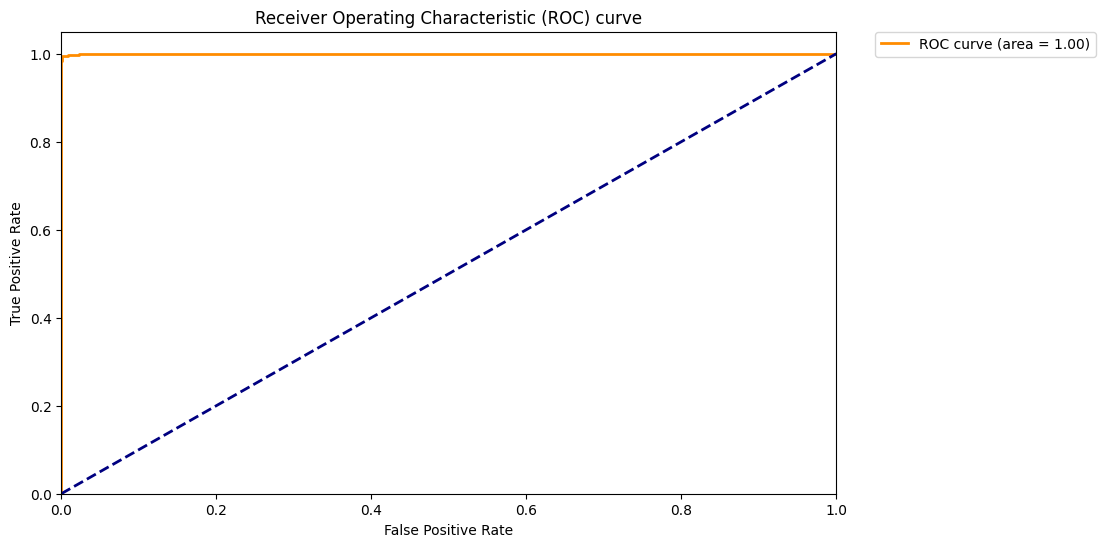

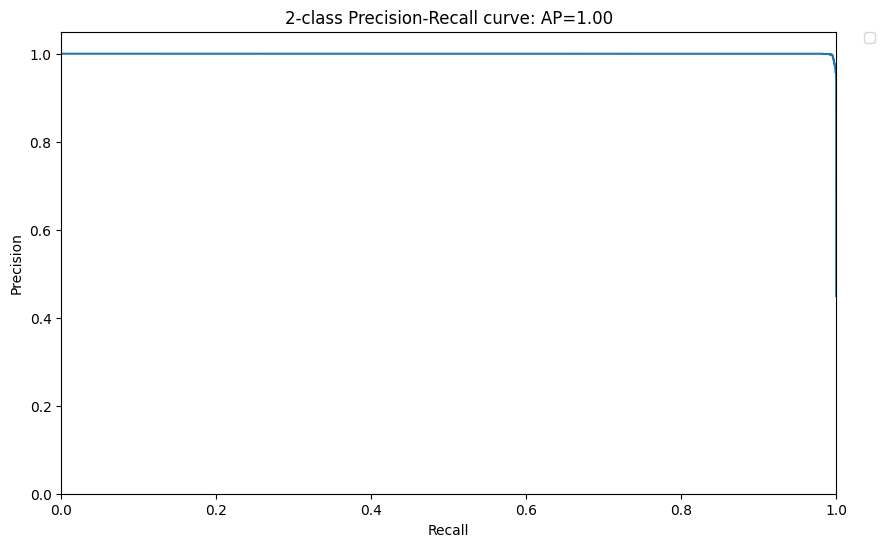

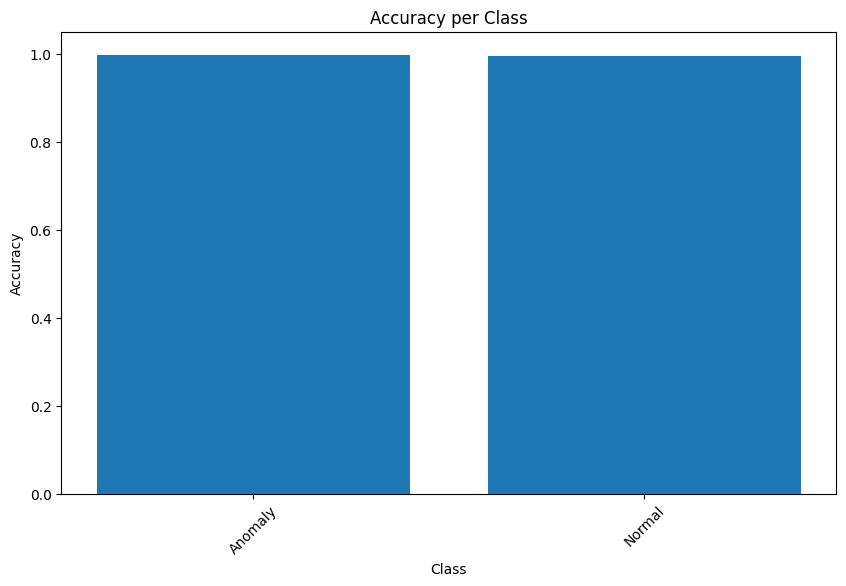

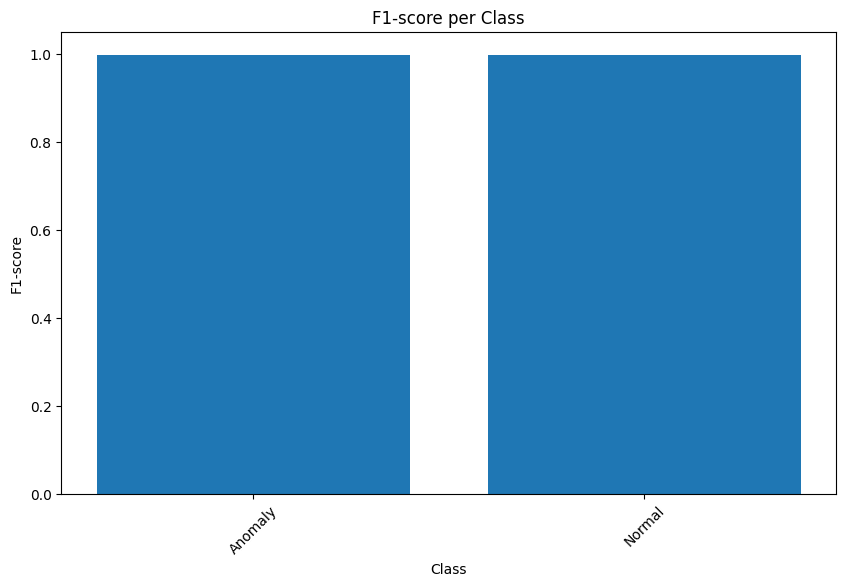

In [8]:
# Calculate prediction probabilities
y_score = model.predict(X_test)

model_name = "Transformer"

# Select probabilities for the positive class
y_score_pos = y_score[:, 1]

# Print scores and plot metrics
print_score(y_pred, y_test, y_score_pos, le, model_name)
plot_roc_curve(y_test, y_score_pos, le, model_name)
plot_precision_recall_curve(y_test, y_score_pos, le, model_name)
plot_class_accuracy(y_test, y_pred, le, model_name)
plot_class_f1_score(y_test, y_pred, le, model_name)
